# Tokyo Airbnb Price Prediction - Comparision of Gradient Boosting and Deep Learning

This notebook contains the code to accompany chapter 12 of [Machine Learning with Tabular Data](https://www.manning.com/books/machine-learning-on-tabular-data). In this code we compare the [XGBoost solution to the Tokyo Airbnb price prediction problem](https://github.com/lmassaron/ml_on_tabular_data/blob/main/chapter_07/chapter_07.ipynb) adapted from chapter 7 with a fastai solution.

In [14]:
# ingest the Airbnb Tokyo dataset
import pandas as pd
url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/airbnb_tokyo.csv"
airbnb_tokyo = pd.read_csv(url)

In [15]:
y = airbnb_tokyo["target"]
X = airbnb_tokyo.iloc[:, :-1].set_index("listing_id")

In [16]:
# list columns in the dataset
X.columns

Index(['onehot_encoding__room_type_Entire home/apt',
       'onehot_encoding__room_type_Hotel room',
       'onehot_encoding__room_type_Private room',
       'onehot_encoding__room_type_Shared room',
       'ordinal_encoding__neighbourhood_more_than_30',
       'ordinal_encoding__type_of_accommodation',
       'target_encoding__coordinates', 'numeric__minimum_nights',
       'numeric__number_of_reviews', 'numeric__days_since_last_review',
       'numeric__reviews_per_month', 'numeric__calculated_host_listings_count',
       'numeric__availability_365', 'numeric__score',
       'numeric__number_of_reviews_ltm',
       'numeric__number_of_reviews_ltm_ratio', 'numeric__number_of_bedrooms',
       'numeric__number_of_beds', 'numeric__number_of_baths',
       'numeric__imperial_palace_distance',
       'numeric__nearest_convenience_store', 'numeric__nearest_train_station',
       'numeric__nearest_airport', 'numeric__nearest_bus_station',
       'numeric__nearest_subway', 'binary__is_new', 

In [17]:
# Define a five-fold stratified random splitting using sklearn Stratified K-Folds cross-validator
from sklearn.model_selection import StratifiedKFold

neighbourhood_more_than_30 = X["ordinal_encoding__neighbourhood_more_than_30"].astype(int)
cv = StratifiedKFold(5, shuffle=True, random_state=0) #A



In [18]:
# define values for the XGBoost hyperparameters
'''
xgb_params = {'booster': 'gbtree',
              'colsample_bytree': 0.946407058507176,
              'learning_rate': 0.06867015067874482,
              'max_depth': 7,
              'min_child_weight': 5,
              'n_estimators': 901,
              'objective': 'reg:tweedie',
              'reg_alpha': 0.0006368936493084075,
              'reg_lambda': 3.8302865696045996,
              'subsample': 0.8956307610431394,
              'tweedie_variance_power': 1.560801988491813}'''

xgb_params =  {'booster': 'gbtree',
               'objective': 'reg:tweedie',
               'n_estimators': 932,
               'learning_rate': 0.08588055025922144,
               'subsample': 0.9566295202123205,
               'colsample_bytree': 0.6730567082779646,
               'max_depth': 7,
               'min_child_weight': 6,
               'reg_lambda': 6.643211493348415e-06,
               'reg_alpha': 7.024597970671363e-05,
               'tweedie_variance_power': 1.6727891016980427}

In [19]:
# define and train the XGBoost model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

xgb = XGBRegressor(**xgb_params) #A

cv_splits = cv.split(X, y=neighbourhood_more_than_30) #B

r2_scores = []
rmse_scores = []
mae_scores = []
xgb_oof_preds = np.zeros(len(X))

for train_index, test_index in cv_splits: #C
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test) #D
    xgb_oof_preds[test_index] = y_pred

    r2_scores.append(r2_score(y_test, y_pred)) #E
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Mean cv R-squared: {np.mean(r2_scores):.3f}") #F
print(f"Mean cv RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean cv MAE: {np.mean(mae_scores):.3f}")

#A set up an XGBoost regressor with the specified hyperparameters
#B define cross-validation splits based on the neighbourhood_more_than_30 feature
#C generate cross-validation splits based on the neighbourhood_more_than_30 feature
#D perform cross-validated predictions
#E calculate R-squared, RMSE, and MAE evaluation metrics to assess the model's performance
#F print the range of predicted values


Mean cv R-squared: 0.732
Mean cv RMSE: 10781.600
Mean cv MAE: 6531.110


In [20]:
from fastai.tabular.all import *
pd.options.mode.chained_assignment=None

In [21]:
# set the pipeline parameters for the fastai model
procs = [FillMissing, Normalize, Categorify]

cat_vars = [col for col in airbnb_tokyo.columns if "onehot_encoding__" in col or "ordinal_encoding__" in col or "binary__" in col]
cont_vars = [col for col in airbnb_tokyo.columns if "numeric__" in col or "target_encoding__" in col]
dep_var = 'target'

In [22]:
# define and train the fastai model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

cv_splits = cv.split(X, y=neighbourhood_more_than_30) #B

r2_scores = []
rmse_scores = []
mae_scores = []
dnn_oof_preds = np.zeros(len(X))

for k, (train_index, test_index) in enumerate(cv_splits): #C
    X_train = airbnb_tokyo.set_index("listing_id").iloc[train_index].copy()
    X_test = airbnb_tokyo.set_index("listing_id").iloc[test_index].copy()
    y_test = airbnb_tokyo["target"].iloc[test_index].copy()

    tab = TabularPandas(X_train, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(),
                        splits=RandomSplitter(valid_pct=0.2, seed=0)(range_of(X_train)),
                        inplace=True, reduce_memory=True)

    dls = tab.dataloaders(bs=128)
    y_range = torch.tensor([0, X_train['target'].max() * 1.2])
    tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=y_range)
    learn = tabular_learner(dls, layers=[1000,500],
                            metrics=mae,
                            config=tc,
                            loss_func=L1LossFlat())
    with learn.no_bar(), learn.no_logging():
        lr = learn.lr_find(show_plot=False)
        learn.fit_one_cycle(80, lr.valley)

    dl = learn.dls.test_dl(X_test)
    y_pred = learn.get_preds(dl=dl)[0].numpy().ravel()
    dnn_oof_preds[test_index] = y_pred

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    print(f"CV Fold {k} MAE: {mae_scores[-1]:.3f}")

print(f"\nMean cv R-squared: {np.mean(r2_scores):.3f}")
print(f"Mean cv RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean cv MAE: {np.mean(mae_scores):.3f}")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

CV Fold 0 MAE: 7068.807


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

CV Fold 1 MAE: 6887.803


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

CV Fold 2 MAE: 6769.054


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

CV Fold 3 MAE: 7084.975


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

CV Fold 4 MAE: 7232.967

Mean cv R-squared: 0.695
Mean cv RMSE: 11512.931
Mean cv MAE: 7008.721


In [23]:
corr = np.corrcoef(xgb_oof_preds, dnn_oof_preds)[0][1]
print(f"Correlation XGBoost & DNN = {corr:.3f}")

Correlation XGBoost & DNN = 0.920


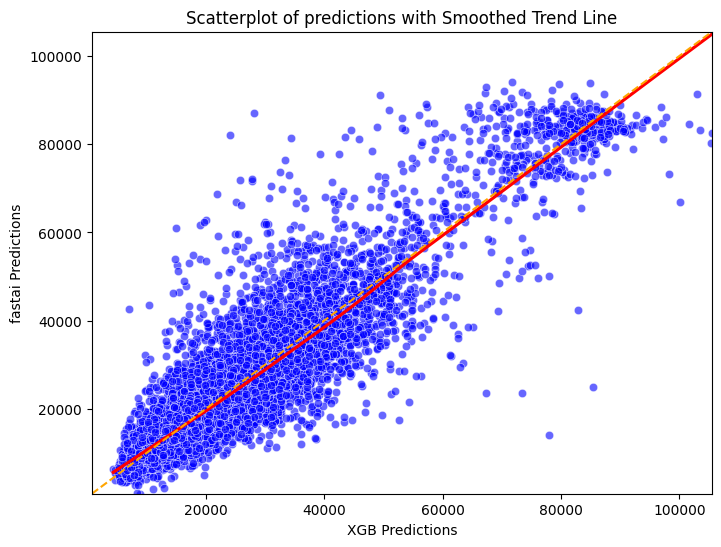

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=xgb_oof_preds, y=dnn_oof_preds, color='blue', alpha=0.6)

# Add a smoothed trend line
sns.regplot(x=xgb_oof_preds, y=dnn_oof_preds, scatter=False, color='red', lowess=True)

# Find the common minimum and maximum values
min_val = min(np.min(xgb_oof_preds), np.min(dnn_oof_preds))
max_val = max(np.max(xgb_oof_preds), np.max(dnn_oof_preds))

# Add the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='orange')

# Add labels and a title
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel('XGB Predictions')
plt.ylabel('fastai Predictions')
plt.title('Scatterplot of predictions with Smoothed Trend Line')

# Show the plot
plt.show()

In [31]:
xgb_oof_preds

array([ 8594.18164062,  8426.36425781, 18286.42578125, ...,
       20486.58398438, 40456.6953125 , 17603.06640625])

In [32]:
xgb_oof_preds.shape


(10041,)

In [36]:
# look at average fastai predictions above and below 70k predictions for XGBoost

combo = np.transpose(np.array([xgb_oof_preds,dnn_oof_preds]))
print(combo.shape)

df = pd.DataFrame(combo, columns = ['xgb','fastai'])
df.head()

(10041, 2)


,xgb,fastai
0,8594.181641,8471.613281
1,8426.364258,7925.265137
2,18286.425781,37379.882812
3,12677.284180,7744.017578
4,8544.852539,7072.970215


In [38]:
avg_fastai = df.loc[df['xgb']>70000, 'fastai'].mean()
print("average fastai value when xgb > 70000 ",avg_fastai)

average fastai value when xgb > 70000  80536.99971543874


In [39]:
avg_fastai = df.loc[df['xgb']<=70000, 'fastai'].mean()
print("average fastai value when xgb <= 70000 ",avg_fastai)

average fastai value when xgb <= 70000  22897.101638615703


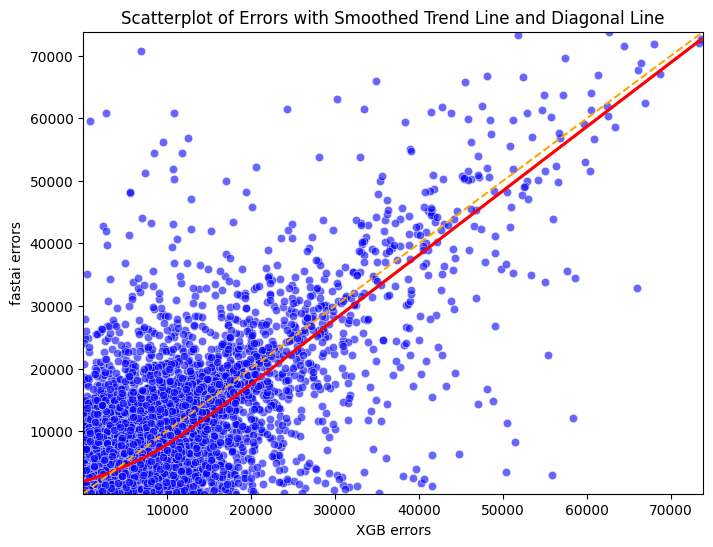

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the differences
xgb_errors = abs(y - xgb_oof_preds)
dnn_errors = abs(y - dnn_oof_preds)

# Find the common minimum and maximum values
min_val = min(np.min(xgb_errors), np.min(dnn_errors))
max_val = max(np.max(xgb_errors), np.max(dnn_errors))

# Create a scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=xgb_errors, y=dnn_errors, color='blue', alpha=0.6)

# Add a smoothed trend line
sns.regplot(x=xgb_errors, y=dnn_errors, scatter=False, color='red', lowess=True)

# Add the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='orange')

# Set both axes to the common minimum and maximum values
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add labels and a title
plt.xlabel('XGB errors')
plt.ylabel('fastai errors')
plt.title('Scatterplot of Errors with Smoothed Trend Line and Diagonal Line')

# Show the plot
plt.show()

In [26]:
# get ensembled predictions
blend_list = [[1.0, 0.0], [0.75, 0.25], [0.5, 0.5], [0.25, 0.75], [0.0, 1.0]]
for a, b in blend_list:
    print(f"XGboost weight={a}, DNN weight={b}")
    blended_oof_preds = xgb_oof_preds * a + dnn_oof_preds * b
    r2 = r2_score(blended_oof_preds, y)
    rmse = np.sqrt(mean_squared_error(blended_oof_preds, y))
    mae = mean_absolute_error(blended_oof_preds, y)
    print(f"blended result for R-squared: {r2:.3f}")
    print(f"blended result for RMSE: {rmse:.3f}")
    print(f"blended result for MAE: {mae:.3f}\n")

XGboost weight=1.0, DNN weight=0.0
blended result for R-squared: 0.599
blended result for RMSE: 10783.027
blended result for MAE: 6531.102

XGboost weight=0.75, DNN weight=0.25
blended result for R-squared: 0.615
blended result for RMSE: 10537.622
blended result for MAE: 6380.637

XGboost weight=0.5, DNN weight=0.5
blended result for R-squared: 0.618
blended result for RMSE: 10584.108
blended result for MAE: 6406.718

XGboost weight=0.25, DNN weight=0.75
blended result for R-squared: 0.608
blended result for RMSE: 10918.758
blended result for MAE: 6605.687

XGboost weight=0.0, DNN weight=1.0
blended result for R-squared: 0.588
blended result for RMSE: 11516.479
blended result for MAE: 7008.727

